<a href="https://colab.research.google.com/github/jaredwool/causal_modeling/blob/main/causal_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1 - Exploring causal graphs and relationships

In [26]:
# install relevant packages
!pip install causalgraphicalmodels dowhy matplotlib scipy graphviz xgboost shap #numpy==1.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 17.8 MB/s eta 0:00:00


In [127]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, pearsonr
import statsmodels.api as sm
import sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels.csm import StructuralCausalModel, linear_model, logistic_model
import dowhy
from dowhy import CausalModel


%matplotlib inline

In [13]:
# define a function to display correlations
def clean_corr(corr_results):
  """
  Takes the output of the scipy.stats.pearsonr function (Pearson correlation) and cleans it up for easy viewing
  Args:
      corr-results: Tuple of floats, the output from scipy.stats.pearsonr
  Returns: None
  """
  print(f"r = {round(corr_results[0], 3)} (p = {round(corr_results[1], 3)})")

In [14]:
# Confounding Example

counfounding_example = StructuralCausalModel({
    'temperature': lambda n_samples: np.random.normal(loc = 23, scale = 3, size = n_samples),
    'price': linear_model(parents = ['temperature'], weights = [2], noise_scale = 5),
    'bookings': linear_model(parents = ['price', 'temperature'], weights = [-1, 5], noise_scale = 5),
})

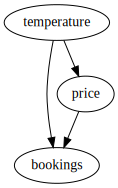

In [15]:
# draw a DAG to represent these relationships
dag1 = counfounding_example.cgm
dag1.draw()

In [16]:
# simulate a dataset using the above relationships
# df = counfounding_example.sample(n_samples = 100000)

n_samples = 100000
temp = np.random.normal(loc = 23, scale = 3, size = n_samples)
price = 2*temp + np.random.normal(loc=0, scale = 5, size = n_samples)
bookings = (-1)*price + 5*temp + np.random.normal(loc = 0, scale = 5, size = n_samples)
df = pd.DataFrame({'temperature':temp, 'price':price, 'bookings':bookings})

df['temperature'] = df['temperature'].round(1)
df['price'] = df['price'].round(2)
df['bookings'] = df['bookings'].astype(int)

df.head()


,temperature,price,bookings
0,23.4,43.66,71
1,28.8,58.36,84
2,23.6,51.03,65
3,21.0,35.10,70
4,21.3,39.48,73


In [17]:
# Calculate the pearson correlation coefficient between price and the number of bookings
clean_corr(pearsonr(df['price'], df['bookings']))

r = 0.325 (p = 0.0)


Text(0.5, 1.0, 'Raw correlation between price and bookings each week')

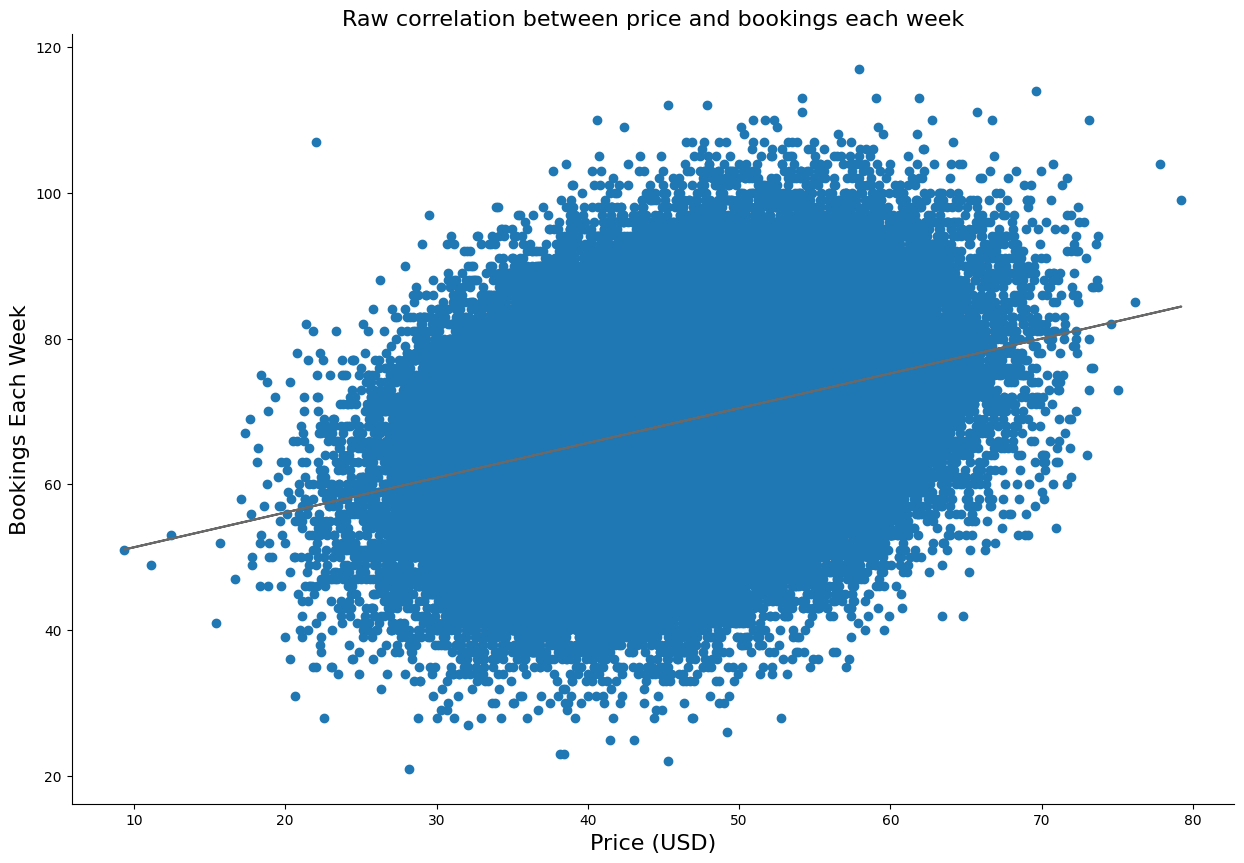

In [18]:
#plot it
plt.rcParams['figure.figsize'] = (15,10)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#include a line of best fit
a, b = np.polyfit(df['price'], df['bookings'], 1)
plt.plot(df['price'], a*df['price']+b, color ='dimgray')

plt.scatter(df['price'], df['bookings'])
plt.ylabel('Bookings Each Week', fontsize = 16)
plt.xlabel('Price (USD)', fontsize=16)
plt.title('Raw correlation between price and bookings each week', fontsize = 16)

In [19]:
# hold temperature constant and then check the correlation between price and bookings and we see the true negative correlation between price and bookings
df2 = df[df['temperature']==20]
clean_corr(pearsonr(df2['price'], df2['bookings']))

r = -0.707 (p = 0.0)


Text(0.5, 1.0, 'Correlation between price and bookings each week holding temperature constant at 20')

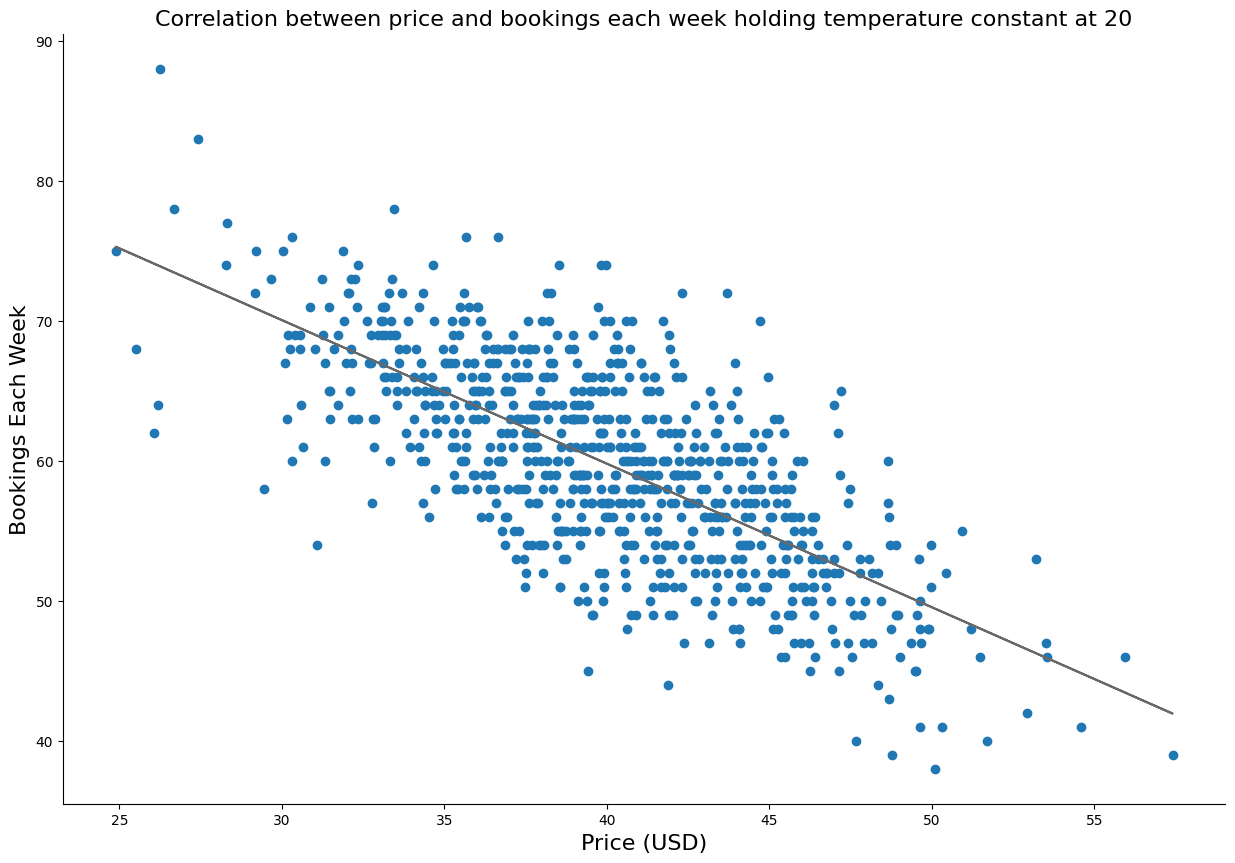

In [20]:
#plot it
plt.rcParams['figure.figsize'] = (15,10)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#include a line of best fit
a, b = np.polyfit(df2['price'], df2['bookings'], 1)
plt.plot(df2['price'], a*df2['price']+b, color ='dimgray')

plt.scatter(df2['price'], df2['bookings'])
plt.ylabel('Bookings Each Week', fontsize = 16)
plt.xlabel('Price (USD)', fontsize=16)
plt.title('Correlation between price and bookings each week holding temperature constant at 20', fontsize = 16)

## Collider

## Mediator

## Causal Feature Importance vs Traditional Feature Importance (Shap Values)

In [176]:
from causalgraphicalmodels.csm import StructuralCausalModel, linear_model
from numpy.random import choice, normal, sample
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import shap
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [177]:
random.seed(42)

In [178]:
# generate the data
n_samples = 10000
temperature = normal(loc=50, scale = 1, size = n_samples)
median_income = normal(loc=10000, scale = 2000, size = n_samples)
population_density = sample(n_samples)
income_inequality = sample(n_samples)
crime = 8*temperature - 0.0005*median_income + 3*population_density + 4*income_inequality + normal(loc=0, scale = 10, size = n_samples)
ice_cream_sales = 3*temperature + 2*median_income + normal(loc = 0, scale = 1, size = n_samples)

df = pd.DataFrame({'temperature':temperature, 'median_income':median_income, 'population_density':population_density, 'income_inequality':income_inequality, 'crime':crime, 'ice_cream_sales':ice_cream_sales})
df.head()

,temperature,median_income,population_density,income_inequality,crime,ice_cream_sales
0,50.937794,11756.468935,0.277632,0.947178,411.386686,23666.414836
1,51.320071,11475.124987,0.198481,0.552129,394.015863,23103.615912
2,49.428378,11179.844418,0.046823,0.370275,402.646565,22508.478916
3,50.559157,9844.500350,0.522147,0.585015,398.986713,19841.010503
4,51.249883,6855.129931,0.313461,0.386383,405.443143,13864.948566


In [179]:
# generate a synthetic dataset
full_example = StructuralCausalModel(
    {
        'temperature': lambda n_samples: normal(loc=50, scale = 1, size = n_samples),
        'median_income': lambda n_samples: normal(loc=10000, scale = 2000, size = n_samples),
        'population_density': lambda n_samples: sample(n_samples),
        'income_inequality': lambda n_samples: sample(n_samples),
        'crime': linear_model(
            parents=['temperature',
                     'median_income',
                     'population_density',
                     'income_inequality'
                    ],
            weights = [3, -0.02, 30, 40],
            noise_scale = 30,
            offset = 200
        ),
        'ice_cream_sales': linear_model(
            parents=[
                'temperature',
                'median_income'
            ],
            weights = [3,1]
        )
    },
)

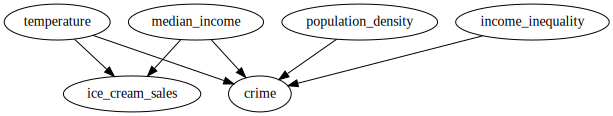

In [180]:
# draw a DAG to represent these relationships
dag2 = full_example.cgm
dag2.draw()

graph [directed 1
	node [id "temperature" label "temperature"]
	node [id "median_income" label "median_income"]
	node [id "population_density" label "population_density"]
	node [id "income_inequality" label "income_inequality"]
	node [id "crime" label "crime"]
	node [id "ice_cream_sales" label "ice_cream_sales"]
	edge [source "temperature" target "crime"]
	edge [source "temperature" target "ice_cream_sales"]
	edge [source "median_income" target "crime"]
	edge [source "median_income" target "ice_cream_sales"]
	edge [source "population_density" target "crime"]
	edge [source "income_inequality" target "crime"]
]



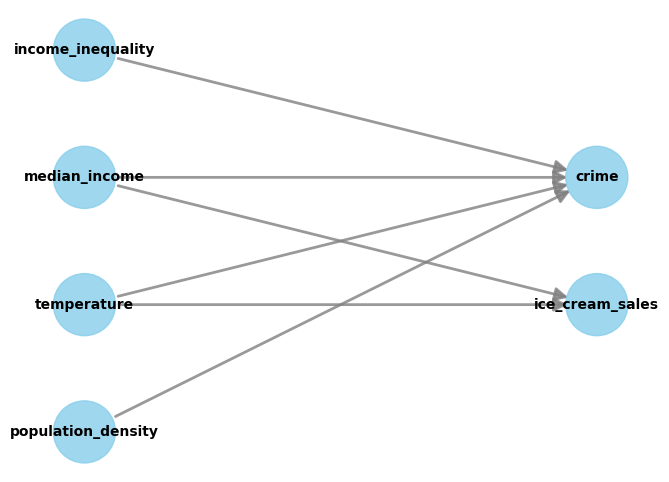

In [181]:
# Alternative DAG

nodes = ['temperature','median_income','population_density','income_inequality','crime','ice_cream_sales']
edges = [['temperature','crime'],
         ['temperature','ice_cream_sales'],
         ['median_income','crime'],
         ['median_income','ice_cream_sales'],
         ['population_density','crime'],
         ['income_inequality','crime']
        ]

gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']\n'
print(gml_graph)

model = CausalModel(
    data = df,
    treatment = 'ice_cream_sales',
    outcome = 'crime',
    graph = gml_graph
)

model.view_model()

In [182]:
# Apply the minmax transformation to the data
scaler = MinMaxScaler()
scaler.fit(df)
df_minmax = scaler.transform(df)
df_minmax = pd.DataFrame(df_minmax, columns = df.columns)
df_minmax.head()

,temperature,median_income,population_density,income_inequality,crime,ice_cream_sales
0,0.627994,0.616341,0.277687,0.947186,0.593255,0.616381
1,0.681273,0.595926,0.198503,0.552128,0.420894,0.595965
2,0.417622,0.574499,0.046781,0.370271,0.506531,0.574375
3,0.575222,0.477602,0.522306,0.585015,0.470217,0.477610
4,0.671491,0.260682,0.313532,0.386379,0.534280,0.260821


Text(0.5, 1.0, 'Raw correlation between Crime and Ice Cream Sales')

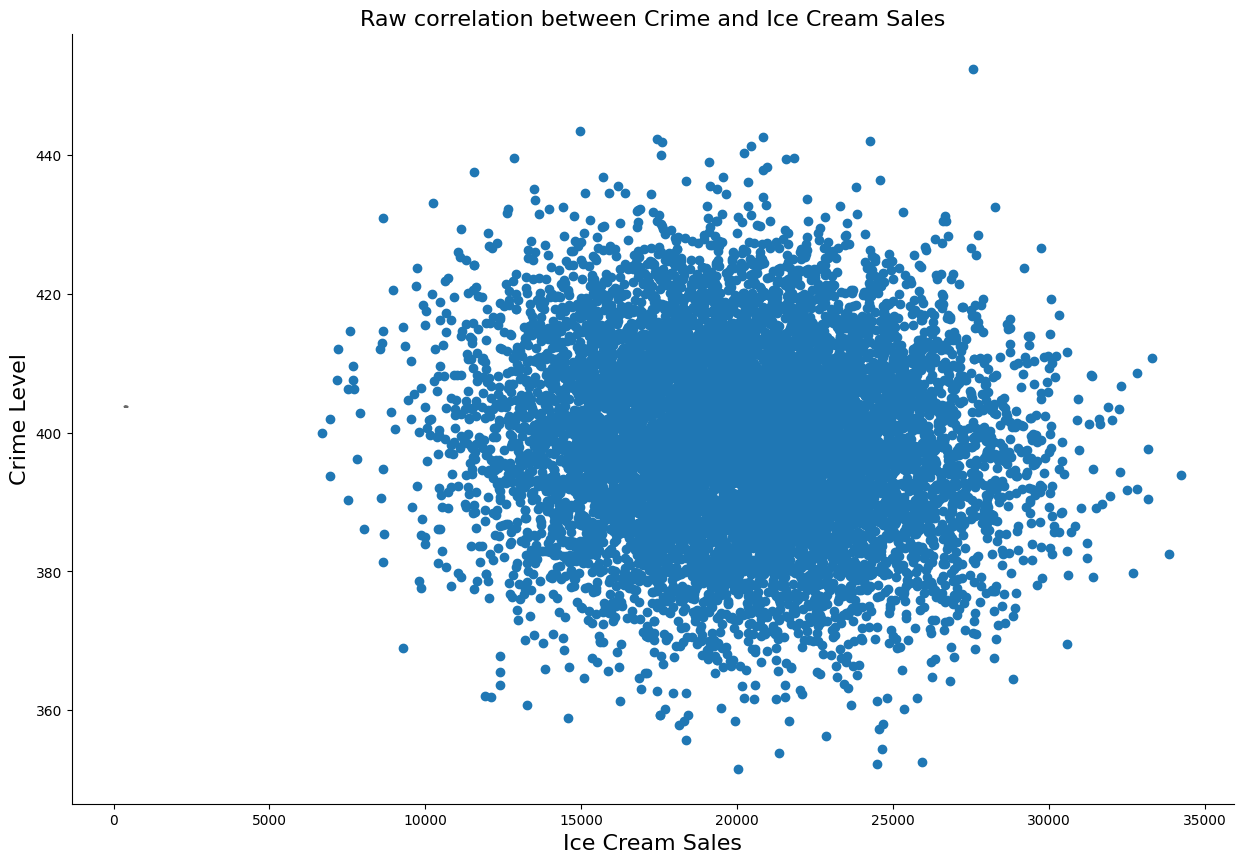

In [183]:
#plot ice cream and crime
plt.rcParams['figure.figsize'] = (15,10)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#include a line of best fit
a, b = np.polyfit(df['ice_cream_sales'], df['crime'], 1)
plt.plot(df['crime'], a*df['crime']+b, color ='dimgray')

plt.scatter(df['ice_cream_sales'], df['crime'])
plt.ylabel('Crime Level', fontsize = 16)
plt.xlabel('Ice Cream Sales', fontsize=16)
plt.title('Raw correlation between Crime and Ice Cream Sales', fontsize = 16)

In [139]:
# naive regression of ice cream sales on crime
print('Original Data')
X = df[['ice_cream_sales']]
y = df[['crime']]

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

# Transformed data
print('Transformed Data')
X = df_minmax[['ice_cream_sales']]
y = df_minmax[['crime']]

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

Original Data
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             404.1713      0.671    602.673      0.000     402.857     405.486
ice_cream_sales    -0.0003   3.26e-05     -8.589      0.000      -0.000      -0.000
Transformed Data
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5385      0.006     82.999      0.000       0.526       0.551
ice_cream_sales    -0.1027      0.012     -8.589      0.000      -0.126      -0.079


In [140]:
# block backdoor pathways by controlling for median income and temperature
X = df[['ice_cream_sales','median_income','temperature']]
y = df[['crime']]

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

# Transformed data
print('Transformed Data')
X = df_minmax[['ice_cream_sales','median_income','temperature']]
y = df_minmax[['crime']]

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.8759      5.081     -0.763      0.446     -13.835       6.084
ice_cream_sales    -0.1205      0.101     -1.189      0.235      -0.319       0.078
median_income       0.2405      0.203      1.186      0.236      -0.157       0.638
temperature         8.5161      0.320     26.573      0.000       7.888       9.144
Transformed Data
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1842      0.012     14.809      0.000       0.160       0.209
ice_cream_sales   -44.1766     37.167     -1.189      0.235    -117.032      28.678
median_income      44.0792     37.168      1.186      0.236     -28.777     116.935
temperature         0.6912      0.026     26.573      0.000

In [141]:
X = df[['ice_cream_sales','median_income', 'temperature', 'population_density', 'income_inequality']]
y = df[['crime']]

In [142]:
bst = XGBRegressor()
bst.fit(X = X, y = y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

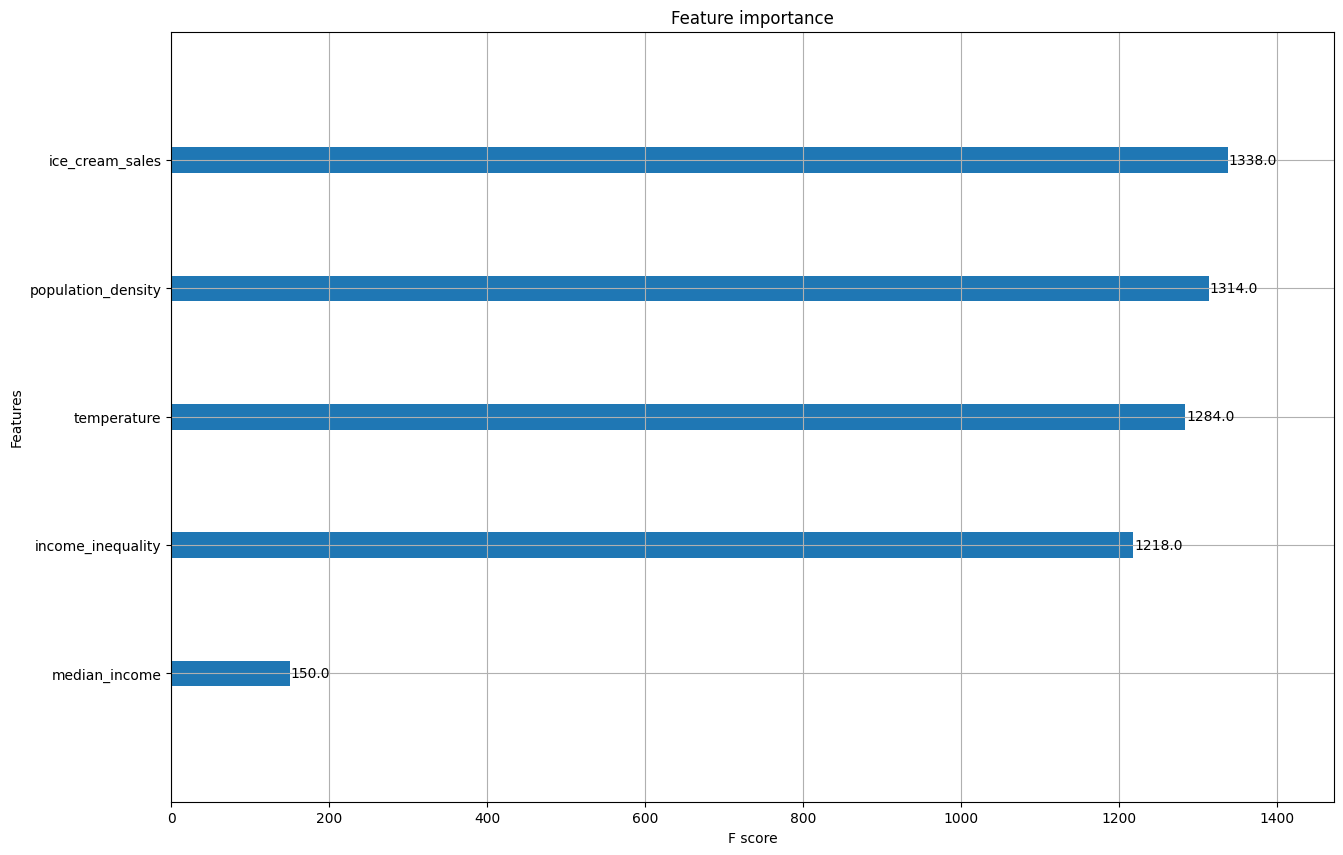

In [143]:
plot_importance(bst)
plt.show()

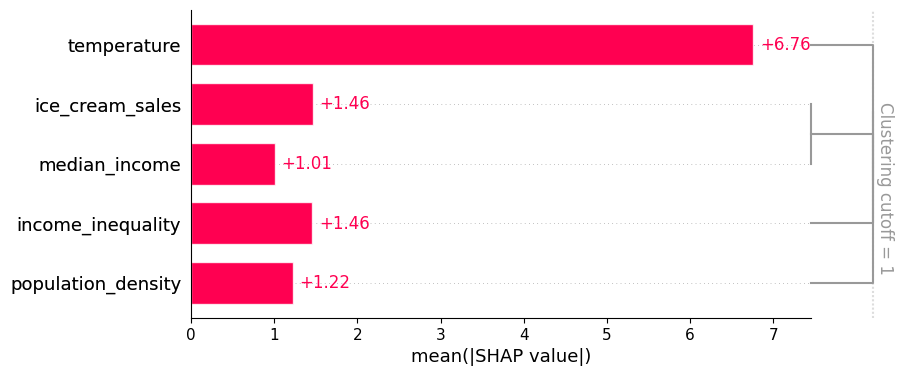

In [144]:
# Use Shap and we get similar conclusions
explainer = shap.Explainer(bst)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage='single')

shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [145]:
# Define a function to convert all numerical columns in a dataframe to binary
def binarize_df(data):
  """
  This function takes a pandas DataFrame and binarizes all numerical columns based on their median values.

  Args:
  df: A Pandas DataFrame.

  Returns:
  A Pandas DataFrame with all numerical columns binarized.
  """
  # Select numerical columns
  num_cols = data.select_dtypes(include=['int64', 'float64']).columns

  #binarize each numerical column and add it to a new dataframe
  df=pd.DataFrame()
  for col in num_cols:
    median = data[col].median()
    df[col] = (data[col] >= median).astype(int)

  return df

In [146]:
df_bin = binarize_df(data=df)
df_bin.head()

,temperature,median_income,population_density,income_inequality,crime,ice_cream_sales
0,1,1,1,0,1,1
1,1,0,0,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,1,0
4,0,1,1,0,1,1


### S-Learner Methodology


*   Train the meta-learner(XGBoost, Neural Network, Logistic, OLS, etc) based on the causal structure of the data ensuring all confounders are controlled for and any colliders and mediators are not controlled for
*   For each feature, we create two new datasets, one where we replace the values for that feature to all 1s, and another where we replace to all 0's
*   Use each fitted model to predict the probability of the dependent variable
*   Use the mean difference of the prediction on the two datasets as the average treatment effect



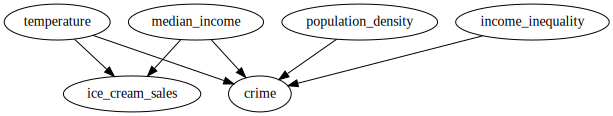

In [148]:
dag2.draw()

In [149]:
# Define a function that takes the dataframe, dependent and independent variables as arguments, fits a model with relevant controls, generates predicted values based on intervening on the relevant variable forcing it to zeros and then ones respectivley and generating predicted values. then calculate the difference in average predicted value to uncover the causal average treatment effect

def ate(data, target, treatment, controls):
  """
  This function takes a dataframe, a target variable, a treatment variable and control variables and uses S-learner techniques to compute the Causal Average Treatment Effect

  Args:
  data: A Pandas DataFrame
  target: The column name of the target variable (dependent Variable)
  treatment: (assumes binary treatment) The column name for the treatment variable of interest (one of the independent variables)
  controls: include an empty set if no controls are desired. A list of column names that comprise a sufficient of control variables to block all backdoor pathways between the treatment and outcome variables (remaining independent variables)

  Returns:
  The Causal Average Treatment Effect of the treatment variable on the target assuming all backdoor pathways are blocked by the control set
  """

  # Define the model parameters
  X = data[[treatment] + controls]
  y = data[target]

  bst = XGBClassifier()
  bst.fit(X, y)

  # create two versions of the dataset where we force the treatment variable to be either 0 or 1 for all observations
  X0 = X.copy()
  X1 = X.copy()
  X0[treatment] = 0
  X1[treatment] = 1

  # generate predicted values for each scenario
  p0 = bst.predict_proba(X0)[:, 1]
  p1 = bst.predict_proba(X1)[:, 1]
  ate = np.mean(p1 - p0)
  return ate

In [150]:
# Ice cream - ice cream's effect on crime is confounded by temperature and median income
ic_ate = ate(data = df_bin, target = 'crime', treatment = 'ice_cream_sales', controls = ['temperature', 'median_income'])

# temperature = temperature has no confounding variables. Ice cream is a collider so if we erroneously control for that we will open a pathway for spurious correlation
temp_ate = ate(data=df_bin, target = 'crime', treatment = 'temperature', controls = [])

# median income - median income has no confounding variables. Ice cream is a collider so if we erroneously control for ice cream we will open a pathway for spurious correlation
medinc_ate = ate(data=df_bin, target = 'crime', treatment = 'median_income', controls = [])

# Population Density - has no confounding variables
pd_ate = ate(data=df_bin, target = 'crime', treatment = 'population_density', controls = [])

# Income Inequality has no confounding variables
incineq_ate = ate(data=df_bin, target = 'crime', treatment = 'income_inequality', controls = [])

#combine them all into a dataframe
causal_ate_df = pd.DataFrame({
    'name': ['ice_cream_sales', 'temperature', 'median_income', 'population_density', 'income_inequality'],
    'values': [ic_ate, temp_ate, medinc_ate, pd_ate, incineq_ate]
})
# apply absolute value to all ate values
causal_ate_df['values'] = np.abs(causal_ate_df['values'])
causal_ate_df.sort_values('values', ascending=False, inplace = True)
causal_ate_df

,name,values
1,temperature,0.451192
4,income_inequality,0.081592
3,population_density,0.050790
2,median_income,0.050390
0,ice_cream_sales,0.001445


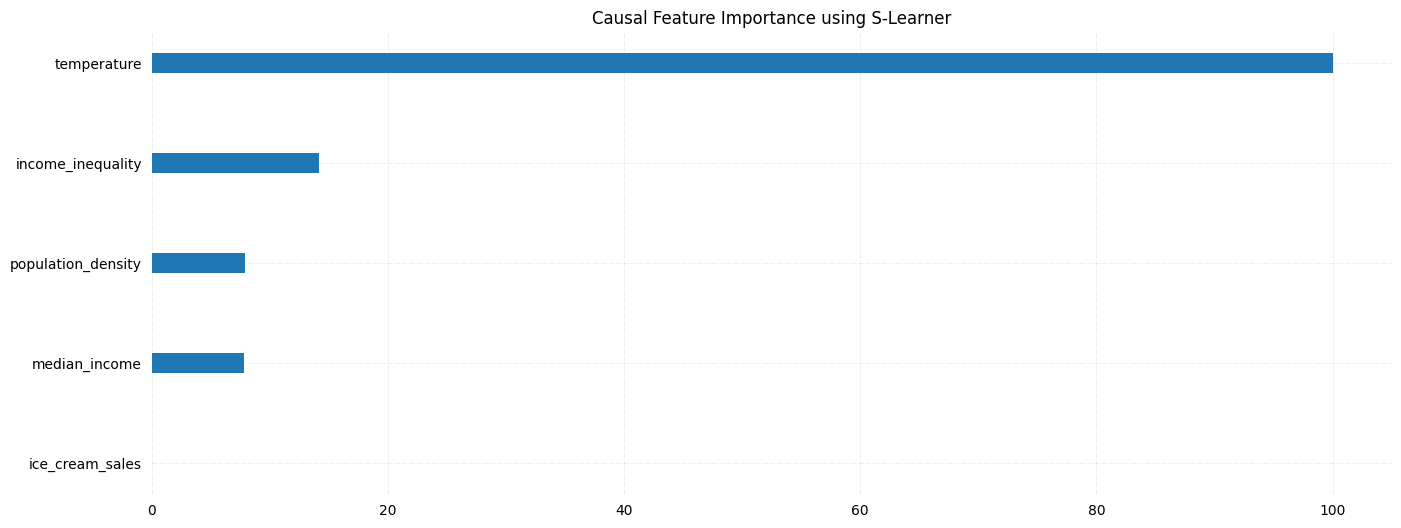

In [175]:
# plot the Causal Feature Importance Values

#Figure Size
fig, ax = plt.subplots(figsize = (16, 6))

# Horizontal BAr Plot
ax.barh(causal_ate_df['name'].tolist(), causal_ate_df['values'].tolist(), height=0.2)

# Remove Axes splines
for s in ['top', 'bottom', 'left', 'right']:
  ax.spines[s].set_visible(False)

# Remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add x, y gridlines
ax.grid(color = 'grey',
        linestyle = '-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add Plot Title
ax.set_title('Causal Feature Importance using S-Learner')

plt.show()

In [169]:
# OLS Regression based approach to Causal Feature Importance
# Define a function that takes the dataframe, dependent and independent variables as arguments, fits a model with relevant controls, generates predicted values based on intervening on the relevant variable forcing it to zeros and then ones respectivley and generating predicted values. then calculate the difference in average predicted value to uncover the causal average treatment effect

def causal_feature_importance_OLS(data, target, treatment, controls):
  """
  This function takes a dataframe, a target variable, a treatment variable and control variables, standardizes all variables using the minimax transformation then uses OLS technique to compute the Causal Average Treatment Effect
  The feature importance is determined by the absolute value of the size of the t-value
  Since all analyses use the same number of observations the relative absolute value of the
  t-value captures the magnitude of the effect regardless of scaling

  Args:
  data: A Pandas DataFrame
  target: The column name of the target variable (dependent Variable)
  treatment: The column name for the treatment variable of interest (one of the independent variables)
  controls: Include an empty set if no controls are desired. A list of column names that comprise a sufficient of control variables to block all backdoor pathways between the treatment and outcome variables (remaining independent variables)

  Returns:
  The Causal Average Treatment Effect of the treatment variable on the target assuming all backdoor pathways are blocked by the control set
  """
  # Ensure relevant packages are imported
  import statsmodels.api as sm
  from sklearn.preprocessing import MinMaxScaler

  # Ensure all variables have been transformed using the minimax transformation
  df = pd.DataFrame(sklearn.preprocessing.minmax_scale(
                                                       data[[target] + [treatment] + controls],
                                                       feature_range=(0, 1), axis=0, copy=True
                                                       ),
                    columns = [target] + [treatment] + controls)

  # Define the model parameters
  X = df[[treatment] + controls]
  y = df[target]

  X = sm.add_constant(X)
  ols = sm.OLS(y, X).fit()
  print(ols.summary().tables[1])

  tval = np.abs(ols.tvalues[treatment])

  return tval

In [173]:
# Ice cream - ice cream's effect on crime is confounded by temperature and median income
ic_import = causal_feature_importance_OLS(data = df, target = 'crime', treatment = 'ice_cream_sales', controls = ['temperature', 'median_income'])

# temperature = temperature has no confounding variables. Ice cream is a collider so if we erroneously control for that we will open a pathway for spurious correlation
temp_import = causal_feature_importance_OLS(data=df_bin, target = 'crime', treatment = 'temperature', controls = [])

# median income - median income has no confounding variables. Ice cream is a collider so if we erroneously control for ice cream we will open a pathway for spurious correlation
medinc_import = causal_feature_importance_OLS(data=df_bin, target = 'crime', treatment = 'median_income', controls = [])

# Population Density - has no confounding variables
pd_import = causal_feature_importance_OLS(data=df_bin, target = 'crime', treatment = 'population_density', controls = [])

# Income Inequality has no confounding variables
incineq_import = causal_feature_importance_OLS(data=df_bin, target = 'crime', treatment = 'income_inequality', controls = [])

#combine them all into a dataframe
causal_feature_import = pd.DataFrame({
    'name': ['ice_cream_sales', 'temperature', 'median_income', 'population_density', 'income_inequality'],
    'values': [ic_import, temp_import, medinc_import, pd_import, incineq_import]
})
# rescale values to the range 0, 1
vals = sklearn.preprocessing.minmax_scale(causal_feature_import['values'], feature_range=(0, 10), axis=0, copy=True)
causal_feature_import['values']=vals
causal_feature_import.sort_values('values', ascending=False, inplace = True)
causal_feature_import

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1842      0.012     14.809      0.000       0.160       0.209
ice_cream_sales   -44.1766     37.167     -1.189      0.235    -117.032      28.678
temperature         0.6912      0.026     26.573      0.000       0.640       0.742
median_income      44.0792     37.168      1.186      0.236     -28.777     116.935
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2744      0.006     43.480      0.000       0.262       0.287
temperature     0.4512      0.009     50.554      0.000       0.434       0.469
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const       

,name,values
1,temperature,10.000000
4,income_inequality,1.417571
3,population_density,0.789514
2,median_income,0.781381
0,ice_cream_sales,0.000000


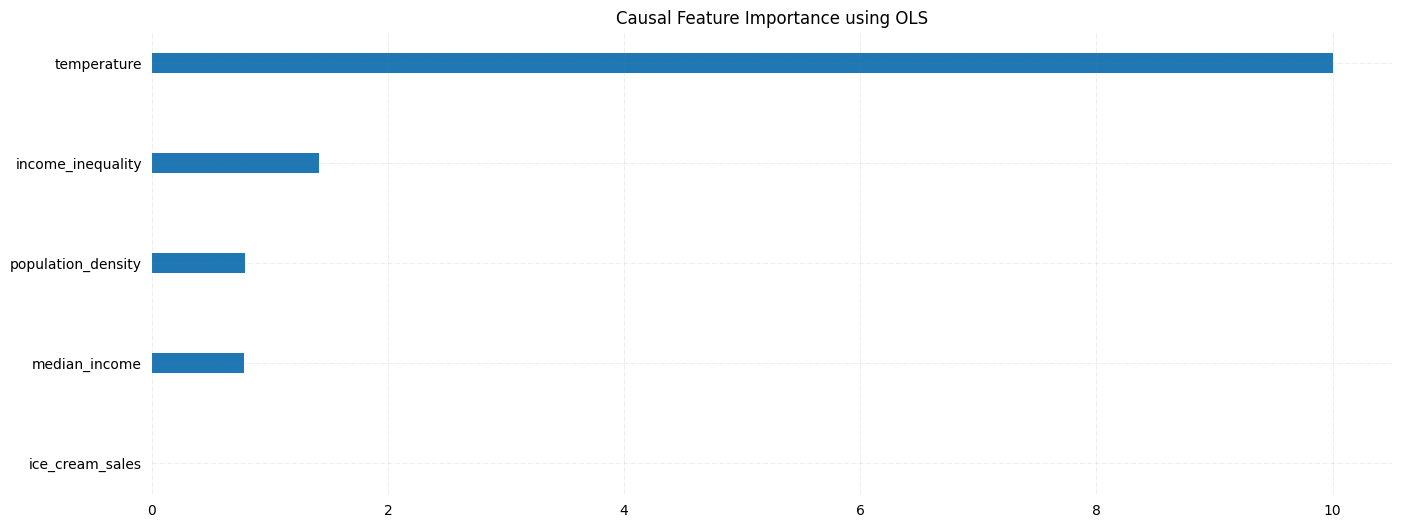

In [174]:
# plot the Causal Feature Importance Values

#Figure Size
fig, ax = plt.subplots(figsize = (16, 6))

# Horizontal Bar Plot
ax.barh(causal_feature_import['name'].tolist(), causal_feature_import['values'].tolist(), height=0.2)

# Remove Axes splines
for s in ['top', 'bottom', 'left', 'right']:
  ax.spines[s].set_visible(False)

# Remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add x, y gridlines
ax.grid(color = 'grey',
        linestyle = '-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add Plot Title
ax.set_title('Causal Feature Importance using OLS')

plt.show()